In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.tree import export_graphviz
# from sklearn.preprocessing import OneHotEncoder

from yellowbrick.features import (FeatureImportances,)
#  conda install -c districtdatalabs yellowbrick 

import sys
sys.path.append('../functions')  # getting to below function

from df_cleaning import df_cleaning  # data celaning function

In [30]:
df = pd.read_csv("../data/insurance.csv")

In [57]:
df_raw = pd.read_csv("../data/insurance.csv")

In [31]:
df = df_cleaning(df)
df.head(5)

1. All duplicated rows within dataset will be dropped. Found: 1 duplicated rows.
2. All missing values within dataset will be replaced with 0. Found: 0 missing values. 


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges
0,19,27.900,0,0,1,0,0,1,16884.92400
1,18,33.770,1,1,0,0,1,0,1725.55230
2,28,33.000,3,1,0,0,1,0,4449.46200
3,33,22.705,0,1,0,1,0,0,21984.47061
4,32,28.880,0,1,0,1,0,0,3866.85520


In [32]:
X = df.drop('charges', axis = 1)
y = df['charges']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [34]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 238, random_seed=42, n_jobs=4, learning_rate=0.225, gamma=0.6, max_depth=3, subsample=0.8378537709017343, colsample_bytree=0.85)

In [35]:
# Fitting the model
xgb_r.fit(X_train, y_train, early_stopping_rounds=10, 
             eval_set=[(X_test, y_test)], 
             verbose=False)

[13:55:17] WARNING: ..\src\learner.cc:576: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\Users\Dell\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85,
             enable_categorical=False, gamma=0.6, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.225, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=238, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_seed=42, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8378537709017343,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
# load data in do training
param = {'max_depth':8, 'eta':0.3, 'objective':'reg:squarederror'}
num_round = 200
dtrain = xg.DMatrix(data=X, label=y)
print('running cross validation')
# do cross validation, this will print result out as
# [iteration]  metric_name:mean_value+std_value
# std_value is standard deviation of the metric
xg_cv = xg.cv(param, dtrain, num_round, nfold=5,
       metrics={'rmse'}, seed=0,
       callbacks=[xg.callback.EvaluationMonitor(show_stdv=True)])

# xgb.cv(
#   params = params,
#   dtrain = dtrain_matrix,
#   num_boost_round=1000,  # Maximum iterations
#   nfold=5, # Number of folds to use
#   metrics = 'rmse', # List of evaluation metrics to be used in cross validation, when it is not specified, the evaluation metric is chosen according to objective function.
#   as_pandas = True,
#   seed = 42,
#   early_stopping_rounds = 10, # Training with a validation set will stop if the performance doesn't improve for n rounds.

# print('running cross validation, disable standard deviation display')
# # do cross validation, this will print result out as
# # [iteration]  metric_name:mean_value
# res = xg.cv(param, dtrain, num_boost_round=100, nfold=5,
#              metrics={'rmse'}, seed=0,
#              callbacks=[xg.callback.EvaluationMonitor(show_stdv=False),
#                         xg.callback.EarlyStopping(5)])
# print(res)
# print('running cross validation, with preprocessing function')
# # define the preprocessing function
# # used to return the preprocessed training, test data, and parameter
# # we can use this to do weight rescale, etc.
# # as a example, we try to set scale_pos_weight
# def fpreproc(dtrain, dtest, param):
#     label = dtrain.get_label()
#     ratio = float(np.sum(label == 0)) / np.sum(label == 1)
#     param['scale_pos_weight'] = ratio
#     return (dtrain, dtest, param)

# # do cross validation, for each fold
# # the dtrain, dtest, param will be passed into fpreproc
# # then the return value of fpreproc will be used to generate
# # results of that fold
# xg_cv = xg.cv(param, dtrain, num_round, nfold=5,
#        metrics={'rmse'}, seed=0, fpreproc=fpreproc)

###
# you can also do cross validation with customized loss function
# See custom_objective.py
##
# print('running cross validation, with customized loss function')
# def logregobj(preds, dtrain):
#     labels = dtrain.get_label()
#     preds = 1.0 / (1.0 + np.exp(-preds))
#     grad = preds - labels
#     hess = preds * (1.0 - preds)
#     return grad, hess
# def evalerror(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'rmse', float(sum(labels != (preds > 0.0))) / len(labels)

# param = {'max_depth':2, 'eta':1}
# # train with customized objective
# xg.cv(param, dtrain, num_round, nfold=5, seed=0,
#        obj=logregobj, feval=evalerror)

running cross validation
[0]	train-rmse:13025.69844+212.00547	test-rmse:13052.50547+938.53490
[1]	train-rmse:9631.88184+148.67029	test-rmse:9782.66094+737.65858
[2]	train-rmse:7312.40088+117.71561	test-rmse:7659.40420+616.33047
[3]	train-rmse:5738.94902+93.55313	test-rmse:6344.80547+554.84906
[4]	train-rmse:4668.38066+79.21289	test-rmse:5573.58955+476.67926
[5]	train-rmse:3948.44702+77.00329	test-rmse:5148.96934+449.05253
[6]	train-rmse:3419.23584+85.65183	test-rmse:4948.07646+420.23190
[7]	train-rmse:3053.49697+87.22282	test-rmse:4852.39756+385.75386
[8]	train-rmse:2772.80986+90.41068	test-rmse:4830.83203+352.67387
[9]	train-rmse:2547.98223+104.48759	test-rmse:4812.60830+350.47538
[10]	train-rmse:2386.22710+124.09568	test-rmse:4828.36367+340.32713
[11]	train-rmse:2245.55825+134.53692	test-rmse:4841.15469+335.30378
[12]	train-rmse:2124.14761+103.67663	test-rmse:4858.48584+317.14384
[13]	train-rmse:2042.23835+126.35936	test-rmse:4865.54727+321.72394
[14]	train-rmse:1981.79429+133.34148	

Text(0.5, 0, 'Round')

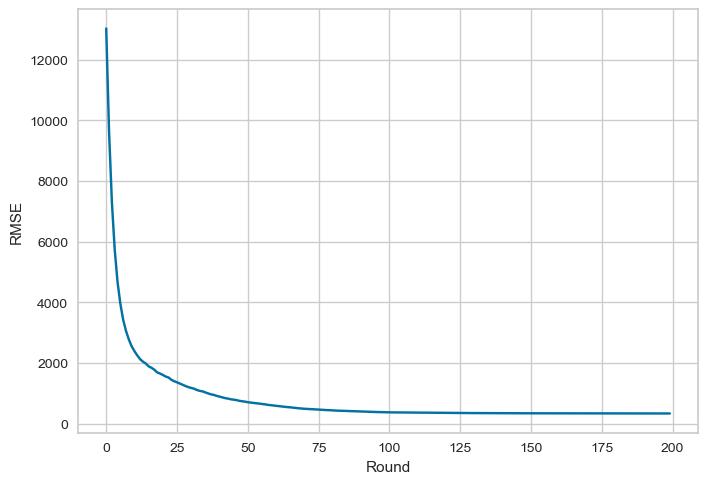

In [37]:
plt.plot(xg_cv.iloc[:,0])
plt.ylabel("RMSE")
plt.xlabel('Round')

In [38]:
y_pred = xgb_r.predict(X_test)
y_pred = pd.DataFrame(y_pred)
MAE_XGB= mean_absolute_error(y_test, y_pred)
MSE_XGB = MSE(y_test, y_pred)
RMSE_XGB =np.sqrt(MSE_XGB)
pd.DataFrame([MAE_XGB, MSE_XGB, RMSE_XGB], index=['MAE_XGB', 'MSE_XGB', 'RMSE_XGB'], columns=['Metrics'])

,Metrics
MAE_XGB,2.799018e+03
MSE_XGB,2.225066e+07
RMSE_XGB,4.717061e+03


In [39]:
# Predict the model
y_pred = xgb_r.predict(X_test)

In [47]:
column_values = ['prediction']

In [48]:
prediction = pd.DataFrame(data=y_pred, columns=column_values)

In [58]:
prediction

,prediction
0,2301.093994
1,9362.400391
2,9526.201172
3,37399.816406
4,8914.897461
...,...
437,22708.023438
438,38981.269531
439,8697.836914
440,19336.832031


In [59]:
df_viz1 = df_raw.join(prediction)

In [60]:
df_viz1

,age,sex,bmi,children,smoker,region,charges,prediction
0,19,female,27.900,0,yes,southwest,16884.92400,2301.093994
1,18,male,33.770,1,no,southeast,1725.55230,9362.400391
2,28,male,33.000,3,no,southeast,4449.46200,9526.201172
3,33,male,22.705,0,no,northwest,21984.47061,37399.816406
4,32,male,28.880,0,no,northwest,3866.85520,8914.897461
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,NaN
1334,18,female,31.920,0,no,northeast,2205.98080,NaN
1335,18,female,36.850,0,no,southeast,1629.83350,NaN
1336,21,female,25.800,0,no,southwest,2007.94500,NaN


In [61]:
df_viz1.dropna()

,age,sex,bmi,children,smoker,region,charges,prediction
0,19,female,27.900,0,yes,southwest,16884.92400,2301.093994
1,18,male,33.770,1,no,southeast,1725.55230,9362.400391
2,28,male,33.000,3,no,southeast,4449.46200,9526.201172
3,33,male,22.705,0,no,northwest,21984.47061,37399.816406
4,32,male,28.880,0,no,northwest,3866.85520,8914.897461
...,...,...,...,...,...,...,...,...
437,35,male,28.900,3,no,southwest,5926.84600,22708.023438
438,52,female,46.750,5,no,southeast,12592.53450,38981.269531
439,26,male,29.450,0,no,northeast,2897.32350,8697.836914
440,31,female,32.680,1,no,northwest,4738.26820,19336.832031


In [93]:
def obese(col):
    if col > 30:
        return 'Obese'
    elif col <= 30 and col > 25:
        return 'Fat'
    elif col <= 25 and col > 18.5:
        return 'Normal'
    else:
        return 'Skinny'
    
df_viz1['bmi_fe'] = df_viz1['bmi'].apply(obese)

<AxesSubplot: >

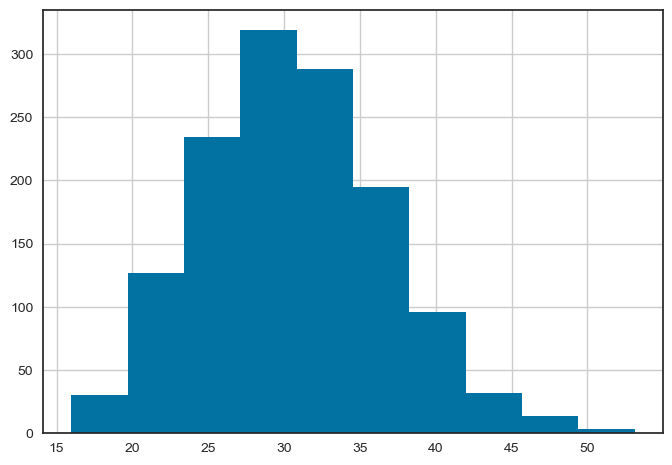

In [76]:
df_viz1.bmi.hist()

In [82]:
df_viz1.children.value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [95]:
df_viz1['child_fe'] = df_viz1['children'] != 0
df_viz1

,age,sex,bmi,children,smoker,region,charges,prediction,child_fe,bmi_fe,age_fe
0,19,female,27.900,0,yes,southwest,16884.92400,2301.093994,False,Fat,Young
1,18,male,33.770,1,no,southeast,1725.55230,9362.400391,True,Obese,Young
2,28,male,33.000,3,no,southeast,4449.46200,9526.201172,True,Obese,Young
3,33,male,22.705,0,no,northwest,21984.47061,37399.816406,False,Normal,Medium
4,32,male,28.880,0,no,northwest,3866.85520,8914.897461,False,Fat,Medium
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,NaN,True,Obese,Old
1334,18,female,31.920,0,no,northeast,2205.98080,NaN,False,Obese,Young
1335,18,female,36.850,0,no,southeast,1629.83350,NaN,False,Obese,Young
1336,21,female,25.800,0,no,southwest,2007.94500,NaN,False,Fat,Young


In [87]:
labels = 'Young', 'Medium', 'Old'
df_viz1['age_fe'] = pd.qcut(df_viz1['age'], len(labels), labels=labels)

In [65]:
y_test

1248     1633.96180
610      8547.69130
393      9290.13950
503     32548.34050
198      9644.25250
           ...     
885     19719.69470
422     39125.33225
294      3906.12700
261     17085.26760
611      6571.54400
Name: charges, Length: 442, dtype: float64

C:\Users\Dell\AppData\Local\Temp\ipykernel_22608\1500204326.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


<AxesSubplot: xlabel='charges', ylabel='prediction'>

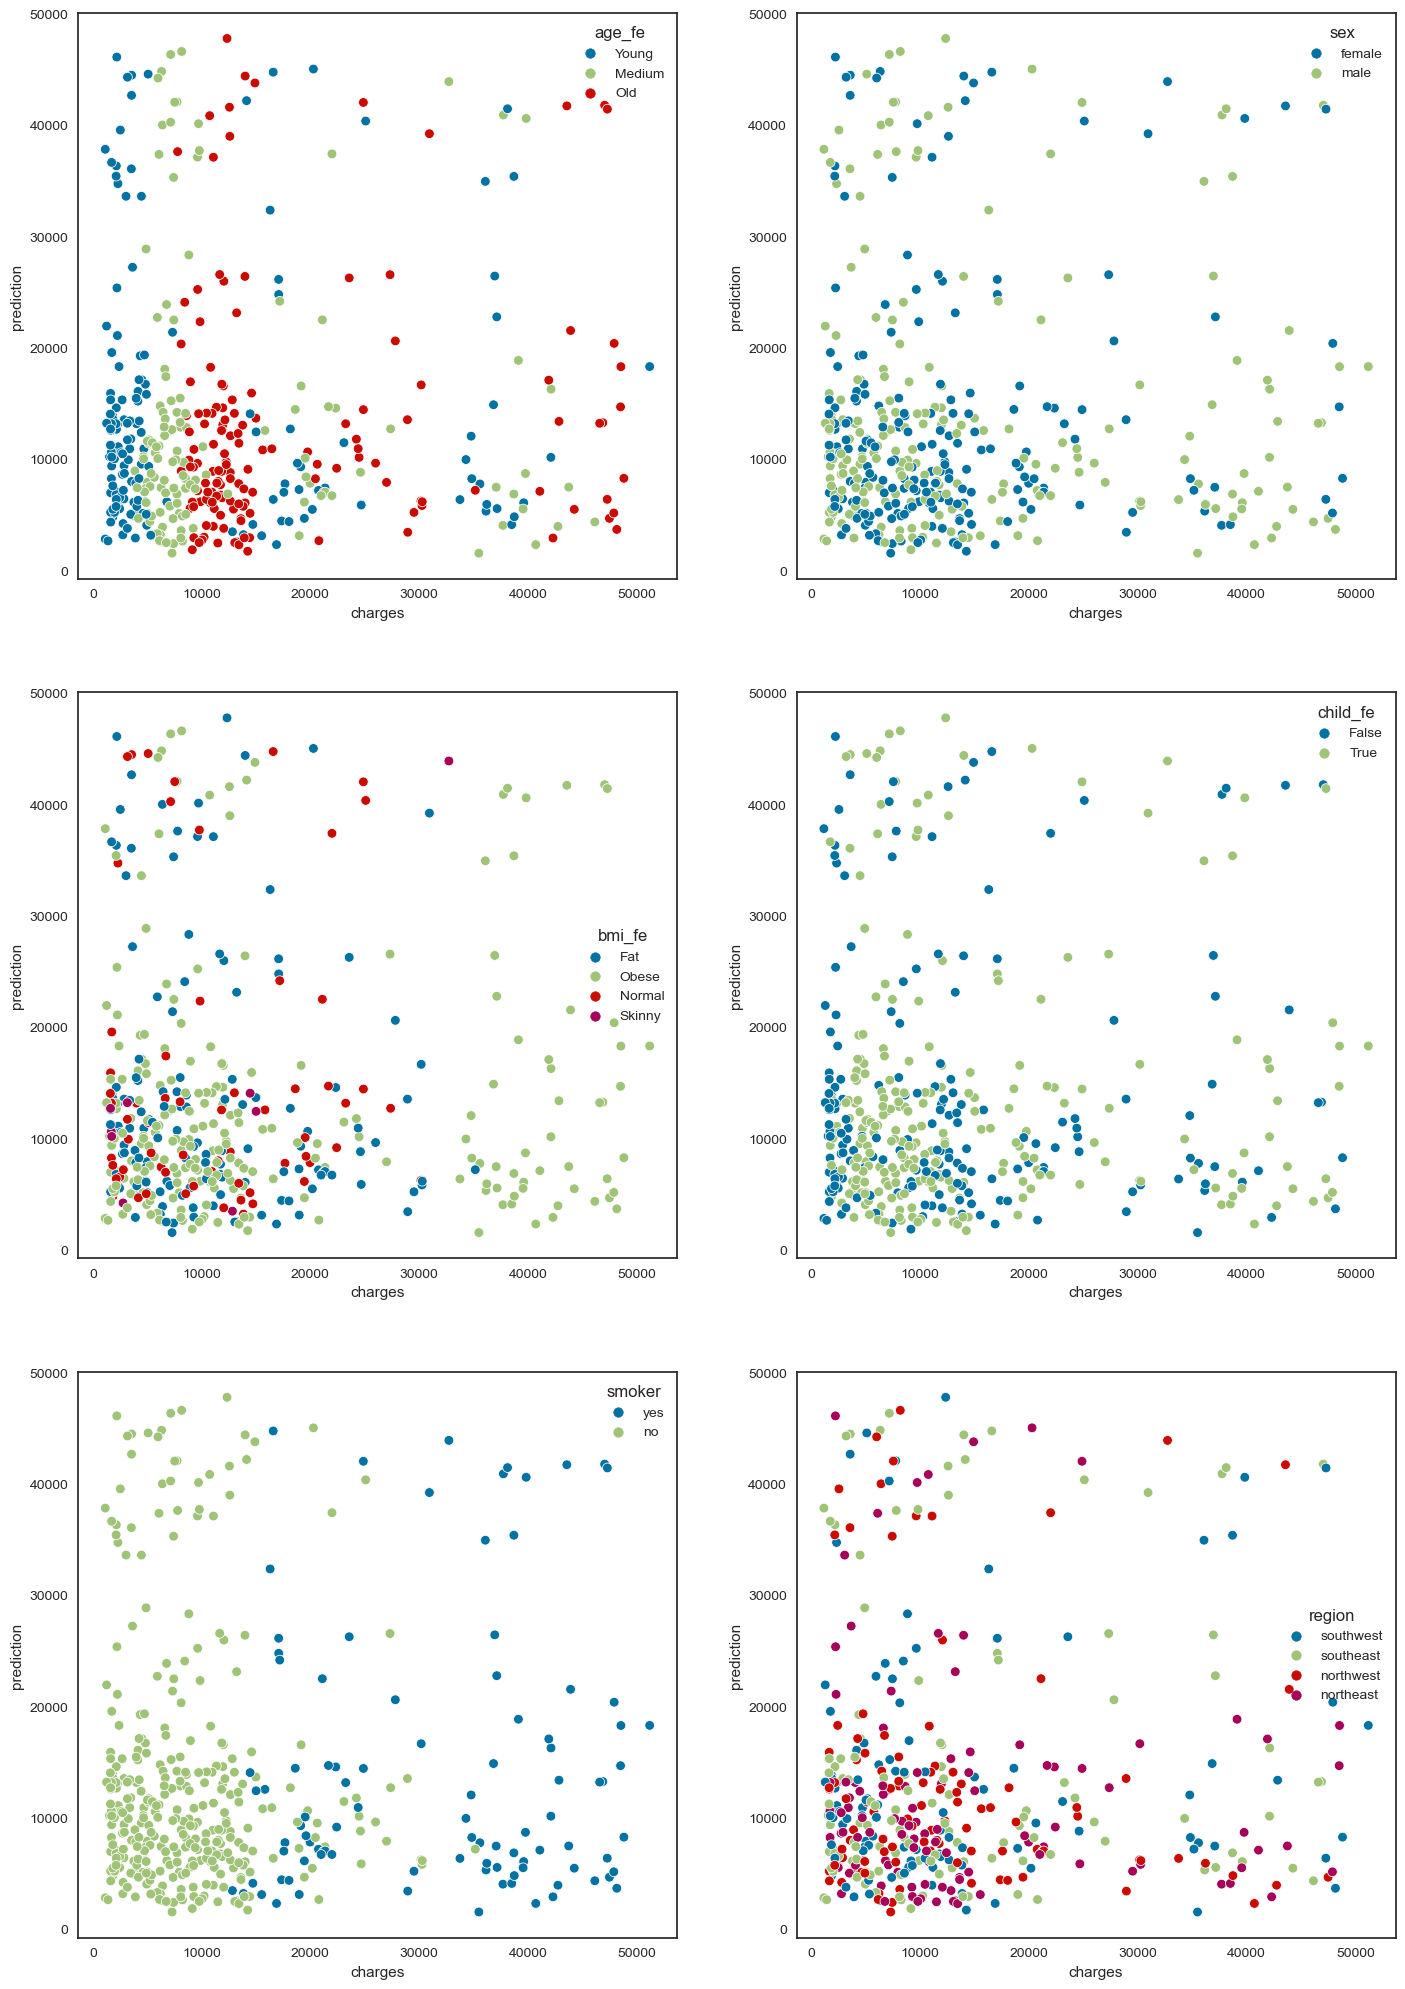

In [94]:
plt.figure(figsize = (17, 25))
plt.style.use('seaborn-white')
plt.subplot(321)
sns.scatterplot(x="charges", y="prediction",hue="age_fe", data=df_viz1)
plt.subplot(322)
sns.scatterplot(x="charges", y="prediction",hue="sex", data=df_viz1)
plt.subplot(323)
sns.scatterplot(x="charges", y="prediction",hue="bmi_fe", data=df_viz1)
plt.subplot(324)
sns.scatterplot(x="charges", y="prediction",hue="child_fe", data=df_viz1)
plt.subplot(325)
sns.scatterplot(x="charges", y="prediction",hue="smoker", data=df_viz1)
plt.subplot(326)
sns.scatterplot(x="charges", y="prediction",hue="region", data=df_viz1)

In [ ]:
y_pred == y_test

In [ ]:
# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_pred))
print("RMSE : % f" %(rmse))

In [ ]:
for col, val in sorted(
    zip(
        X.columns, xgb_r.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
xg.plot_importance(xgb_r, ax=ax)
ax.set(title="Wykres ważności cech", xlabel="Ocena F", ylabel="Cecha")
#fig.savefig("images/mlpr_1405.png", dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set(title="Feature Importance graph", xlabel="Feature importance", ylabel="Feature")
fi_viz = FeatureImportances(xgb_r)
fi_viz.fit(X_train, y_train)
#fig.savefig("images/mlpr_1406.png", dpi=300)

In [ ]:
booster = xgb_r.get_booster()
print(booster.get_dump()[0])

In [ ]:
xgb_r.get_num_boosting_rounds()

In [ ]:
res={}
x=0
for i in xgb_r:
    best,trials=Hopt_run(multi_space[x],10)
    model_name,test,pred=results(multi_space[x])
    res[model_name]=[test,pred]
    # traials_losses.plot()
    print('\nModel name: {}\n'.format(model_name))
    x+=1

In [ ]:
xgb_r

In [ ]:
mod=xgb_r
plt.figure(figsize=(8,6))
plt.scatter(mod[0],mod[1])
plt.title(mod)
plt.xlabel('Y test')
plt.ylabel('Y pred')
plt.grid()
plt.show;

In [ ]:
# fig, ax = plt.subplots(figsize=(24, 16))
# xg.plot_tree(xgb_r, ax=ax, num_trees=0)
# # fig.savefig('images/mlpr_1407.png', dpi=300)